In [ ]:
!git clone https://github.com/rslim087a/track

fatal: destination path 'track' already exists and is not an empty directory.


In [ ]:
!ls track

driving_log.csv  IMG


In [ ]:
!pip3 install imgaug

In [ ]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Dropout,Flatten
import cv2
from imgaug import  augmenters as iaa
from sklearn.utils import  shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import  Adam
import pandas as pd
import ntpath
import random

In [ ]:
datadir='track'
columns=['center','left','right','steering','throttle','reverse','speed']
data=pd.read_csv(os.path.join(datadir,'driving_log.csv'),names=columns)
# pd.set_option('dispaly.max_colwidth',-1)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.649786
1,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.627942
2,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.622910
3,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.619162
4,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.615438


In [ ]:
def path_leaf(path):
  head,tail=ntpath.split(path)
  return tail 

data['center']=data['center'].apply(path_leaf)
data['left']=data['left'].apply(path_leaf)
data['right']=data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2018_07_16_17_11_43_382.jpg,left_2018_07_16_17_11_43_382.jpg,right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,center_2018_07_16_17_11_43_670.jpg,left_2018_07_16_17_11_43_670.jpg,right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,center_2018_07_16_17_11_43_724.jpg,left_2018_07_16_17_11_43_724.jpg,right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,center_2018_07_16_17_11_43_792.jpg,left_2018_07_16_17_11_43_792.jpg,right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,center_2018_07_16_17_11_43_860.jpg,left_2018_07_16_17_11_43_860.jpg,right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


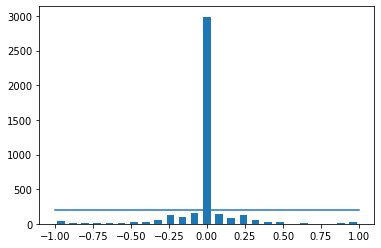

In [ ]:
num_bins=25
sample_per_bin=200
hist,bins=  np.histogram(data['steering'],num_bins)
center=(bins[:-1]+bins[1:])*0.5
plt.bar(center,hist,width=0.05)
plt.plot((np.min(data['steering']),np.max(data['steering'])),(sample_per_bin,sample_per_bin))

total data: 4053
removed: 2790
remaining: 1263


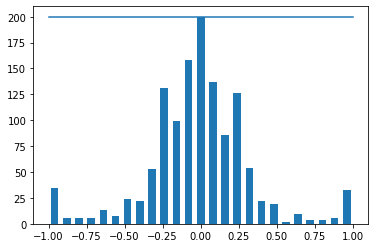

In [ ]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[sample_per_bin:]
  remove_list.extend(list_)

print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
#data.reset_index(drop=True,inplace=True)
print('remaining:', len(data))
 
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (sample_per_bin, sample_per_bin))

In [ ]:
print(data.iloc[1])
def load_img_steering(datadir,df):
  image_path=[]
  steering=[]
  for i in range(len(data)):
    indexed_data=data.iloc[i]
    center,left,right=indexed_data[0],indexed_data[1],indexed_data[2]
    image_path.append(os.path.join(datadir,center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths=np.asarray(image_path) 
  steerings=np.asarray(steering)
  return image_paths,steerings

image_paths,steerings=load_img_steering(datadir + '/IMG',data)

center      center_2018_07_16_17_11_44_413.jpg
left          left_2018_07_16_17_11_44_413.jpg
right        right_2018_07_16_17_11_44_413.jpg
steering                                 -0.05
throttle                              0.642727
reverse                                      0
speed                                  1.43401
Name: 12, dtype: object


In [ ]:
X_train,X_valid,y_train,y_valid=train_test_split(image_paths,steerings,test_size=0.2,random_state=6) 
print('Training samples:{}\nValidation Samples:{}'.format(len(X_train),len(X_valid)))

Training samples:1010
Validation Samples:253


Text(0.5, 1.0, 'Validation set')

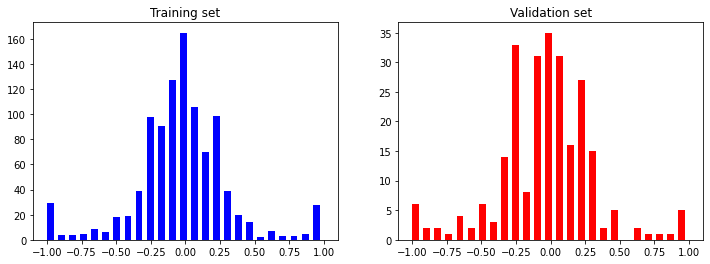

In [ ]:
fig,axes=plt.subplots(1,2,figsize=(12,4))
axes[0].hist(y_train,bins=num_bins,width=0.05,color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid,bins=num_bins,width=0.05,color='red')
axes[1].set_title('Validation set')


In [ ]:
def zoom(image):## zooming in or out or it's called scalling
  zoom=iaa.Affine(scale=(1,1.3))
  image=zoom.augment_image(image)
  return image

Text(0.5, 1.0, 'Zoomed_image')

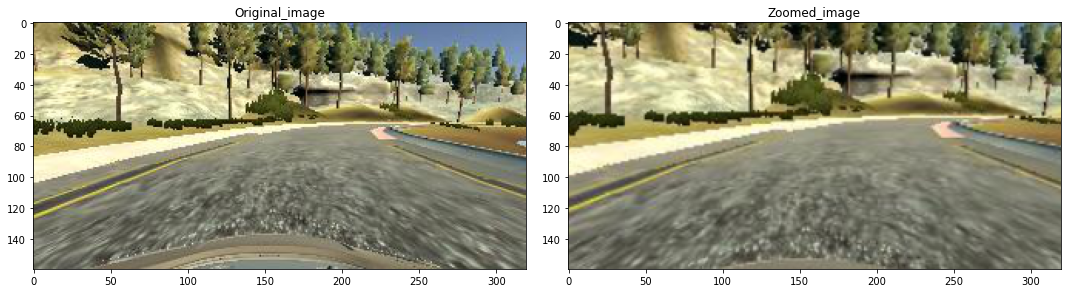

In [ ]:
image=image_paths[random.randint(0,1000)]
original_image=mpimg.imread(image)
zoomed_image=zoom(original_image)
fig,axs=plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original_image')
axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed_image')

In [ ]:
def pan(image):## translate the image w.r.t. axis
  pan=iaa.Affine(translate_percent={"x":(-0-1,0.1),"y":(-0.1,0.1)})
  image=pan.augment_image(image)
  return image

Text(0.5, 1.0, 'Panned_image')

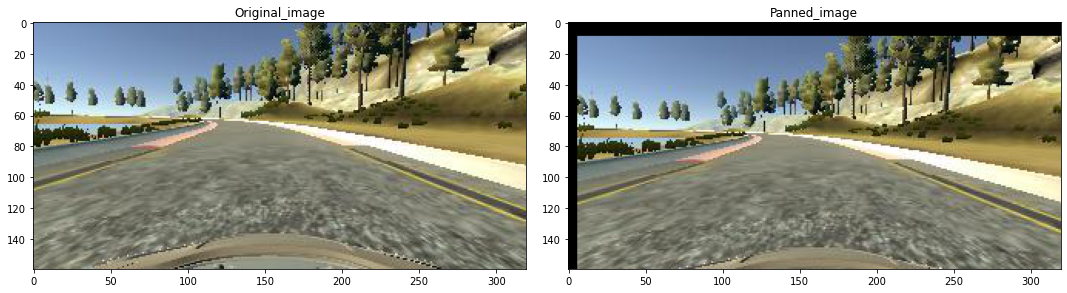

In [ ]:
image=image_paths[random.randint(0,1000)]
original_image=mpimg.imread(image)
panned_image=pan(original_image)

fig,axs=plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original_image')
axs[1].imshow(panned_image)
axs[1].set_title('Panned_image')

In [ ]:
def img_random_brightness(image):
  brighness=iaa.Multiply((0.2,1.2))
  image=brighness.augment_image(image)
  return image

Text(0.5, 1.0, 'Brighttned_image')

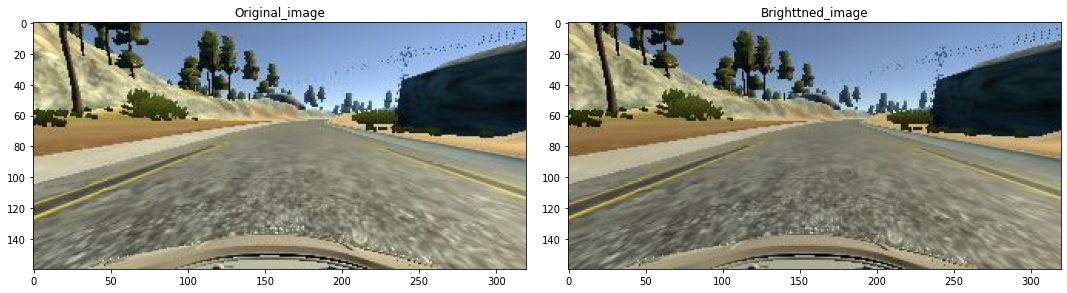

In [ ]:
image=image_paths[random.randint(0,1000)]
original_image=mpimg.imread(image)
brightness_alterd_image=img_random_brightness(original_image)

fig,axs=plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original_image')
axs[1].imshow(brightness_alterd_image)
axs[1].set_title('Brighttned_image')

In [ ]:
def img_random_flip(image,steering_angle):
  image=cv2.flip(image,1)
  steering_angle=-steering_angle
  return image,steering_angle

Text(0.5, 1.0, 'Flipped_image -Steering Angle:-0.25')

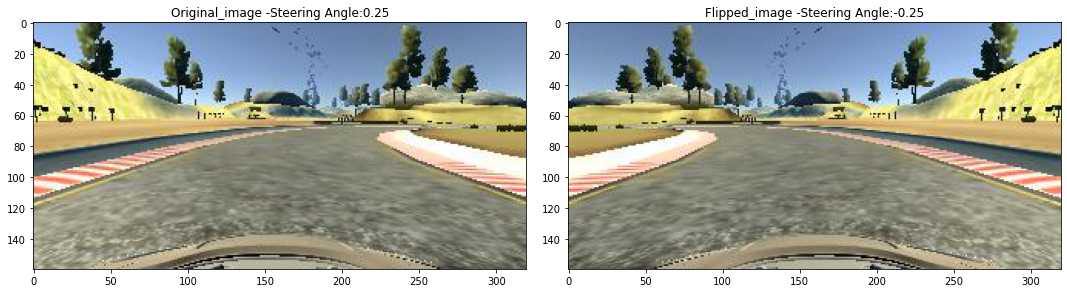

In [ ]:
random_index=random.randint(0,1000)
image=image_paths[random_index]
steering_angle=steerings[random_index]

original_image=mpimg.imread(image)
flipped_image,flipped_steering_angle=img_random_flip(original_image,steering_angle)

fig,axs=plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original_image -'+ 'Steering Angle:'+ str(steering_angle))
axs[1].imshow(flipped_image)
axs[1].set_title('Flipped_image -'+ 'Steering Angle:'+ str(flipped_steering_angle))

In [ ]:
def random_augment(image,steering_angle):
  image=mpimg.imread(image)
  if np.random.rand()<0.5:
    image=pan(image)
  if np.random.rand()<0.5:
    image=zoom(image)
  if np.random.rand()<0.5:
    image=img_random_brightness(image)
  if np.random.rand()<0.5:
    image,steering_angle=img_random_flip(image,steering_angle)
  return image, steering_angle

In [ ]:
ncol=2
nrow=10
fig,axs=plt.subplots(nrow,ncol,figsize=(15,50))
fig.tight_layout()

for i in range(10):
  randnum=random.randint(0,len(image_paths)-1)
  random_image=image_paths[randnum]
  random_steering=steerings[randnum]

  original_image=mpimg.imread(random_image)
  augmented_image,steering=random_augment(random_image,random_steering)

  axs[i][0].imshow(original_image)
  axs[i][0].set_title('Original_image- '+'Steering Angle'+str(steering))

  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title('Augmented_image- '+'Steering Angle'+str(steering))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def img_preprocess(img):
  #img=mpimg.imread(img)
  img=img[60:135,:,:]
  img=cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
  img=cv2.GaussianBlur(img,(3,3),0)
  img=cv2.resize(img,(200,66))
  img=img/255
  return img

Text(0.5, 1.0, 'Preprocessed Image')

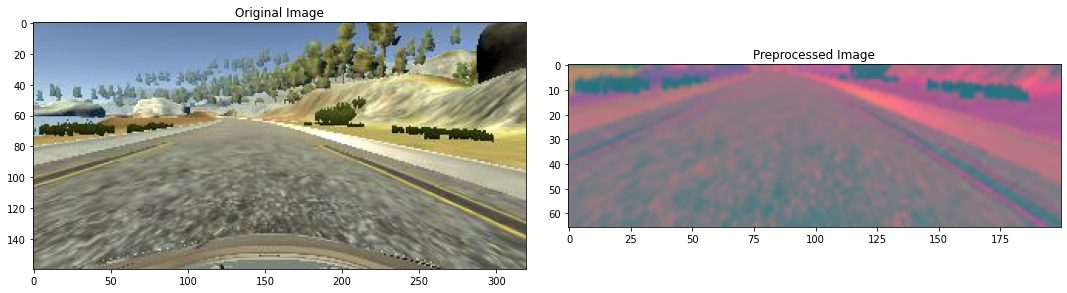

In [ ]:
image=image_paths[100]
original_image=mpimg.imread(image)
preprocessed_image=img_preprocess(image)
fig,axs=plt.subplots(1,2, figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [ ]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
     
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]

      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))  



In [ ]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')
 
axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

ValueError: ignored

In [ ]:
X_train=np.array(list(map(img_preprocess,X_train)))
X_valid=np.array(list(map(img_preprocess,X_valid)))

(1010, 66, 200, 3)


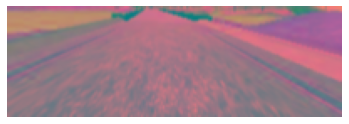

In [ ]:
plt.imshow(X_train[random.randint(0,len(X_train)-1)])
plt.axis('off')
print(X_train.shape)

In [ ]:
def nvidia_model():
  model=Sequential()
  model.add(Conv2D(24,kernel_size=(5,5),strides=(2,2),input_shape=(66,200,3),activation='elu'))
  model.add(Conv2D(36,kernel_size=(5,5),strides=(2,2),activation='elu'))
  model.add(Conv2D(48,kernel_size=(5,5),strides=(2,2),activation='elu'))
  model.add(Conv2D(64,kernel_size=(3,3),activation='elu'))
  model.add(Conv2D(64,kernel_size=(3,3),activation='elu'))
  model.add(Dropout(rate=0.5))

  model.add(Flatten())

  model.add(Dense(100,activation='elu'))
  # model.add(Dropout(0.5))

  model.add(Dense(50,activation='elu'))
  # model.add(Dropout(0.5))

  model.add(Dense(10,activation='elu'))
  # model.add(Dropout(0.5))

  model.add(Dense(1))
  optimizer=Adam(lr=1e-3)
  model.compile(loss='mse',optimizer=optimizer)
  return model

In [ ]:
model=nvidia_model()
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 31, 98, 24)        1824      
                                                                 
 conv2d_26 (Conv2D)          (None, 14, 47, 36)        21636     
                                                                 
 conv2d_27 (Conv2D)          (None, 5, 22, 48)         43248     
                                                                 
 conv2d_28 (Conv2D)          (None, 3, 20, 64)         27712     
                                                                 
 conv2d_29 (Conv2D)          (None, 1, 18, 64)         36928     
                                                                 
 dropout_10 (Dropout)        (None, 1, 18, 64)         0         
                                                                 
 flatten_5 (Flatten)         (None, 1152)             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# h=model.fit(X_train,y_train,epochs=30,validation_data=(X_valid,y_valid),batch_size=100,verbose=1,shuffle=True)
h= model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300, 
                                  epochs=10,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


ValueError: ignored

Text(0.5, 0, 'Epochs')

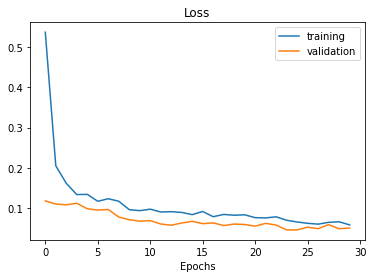

In [ ]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Loss')
plt.xlabel('Epochs')

In [ ]:
model.save('model.h5')

In [ ]:

from google.colab import files
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>